In [2]:
import mujoco
import numpy as np

# Graphics and plotting.
print('Installing mediapy')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

Installing mediapy


""

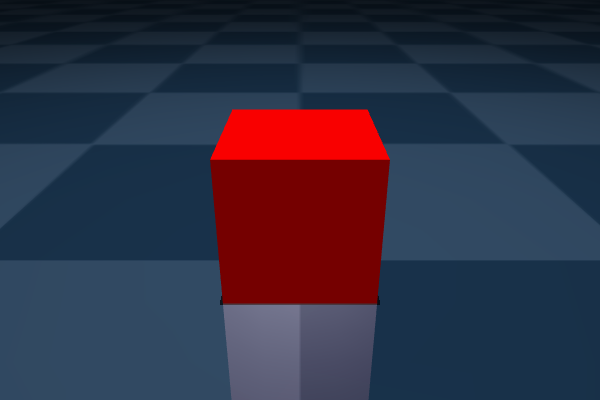

In [3]:
free_body_MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
    rgb2=".2 .3 .4" width="300" height="300" mark="edge" markrgb=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="2 2" texuniform="true"
    reflectance=".2"/>
  </asset>

  <worldbody>
    <light pos="0 0 5" mode="trackcom"/>
    <geom name="ground" type="plane" pos="0 0 -0.1" size="20 20 .1" material="grid" solimp=".99 .99 .01" solref=".001 1" friction=".1"/>
    <body name="box" pos="0 0 0">
      <freejoint/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1" solimp=".99 .99 .01"  solref=".001 1" friction=".1"/>
      <camera name="fixed" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2"/>
      <camera name="track" pos="0 -.6 .3" xyaxes="1 0 0 0 1 2" mode="track"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(free_body_MJCF)
data = mujoco.MjData(model)
height = 400
width = 600

with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, "fixed")
  media.show_image(renderer.render())

In [15]:
n_frames = 100
fps = 30
frames = []
z_positions = []
time_steps  = []  

# visualize contact frames and forces, make body transparent
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT]  = True

# tweak scales of contact visualization elements
model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3

mujoco.mj_resetData(model, data)
data.qpos[2] = 0.    # initial height
data.qvel[0] = 2.    # initial velocity in x direction

# Simulate and display video.
with mujoco.Renderer(model, height, width) as renderer:
    for i in range(n_frames):
        while data.time < i / fps: # real time simulation
            mujoco.mj_step(model, data)
        
        z_positions.append(data.qpos[2])
        time_steps.append(data.time)
            
        renderer.update_scene(data, "track", options)
        frame = renderer.render()
        frames.append(frame)

media.show_video(frames, fps=fps, loop=False)

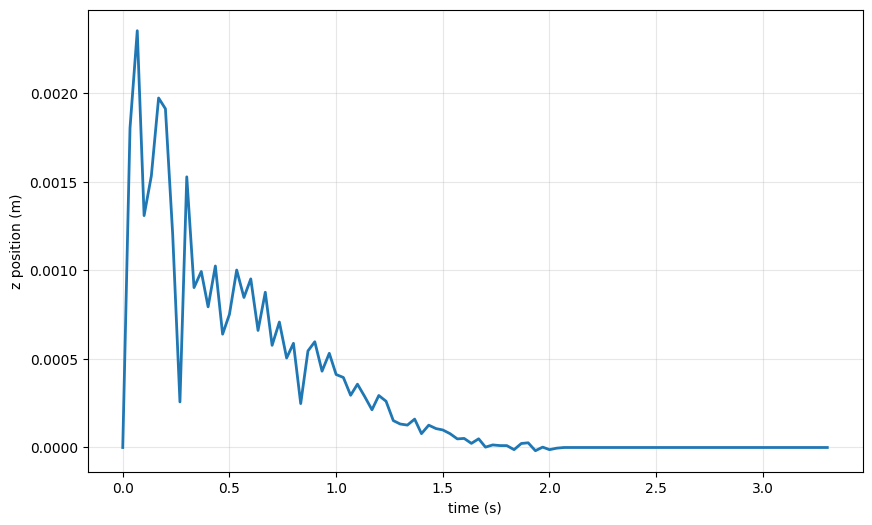

In [16]:
# Plot z positions
plt.figure(figsize=(10, 6))
plt.plot(time_steps, z_positions, '-', linewidth=2)
plt.xlabel('time (s)')
plt.ylabel('z position (m)')
plt.grid(True, alpha=0.3)
plt.show()